In [5]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json
import pandas as pd

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
# from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Problems:
 - For the combined pymc pfds: For stitching the Unconstr HN need to be submitted in front of all Unconstr Gammas in the unconstr dictionary

## Model

Multiple parameters.

In [2]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [0, 0, 0],
     'modifiers': [
        {'name': 'mu_2', 'type': 'normfactor', 'data': None},
        {'name': 'mu', 'type': 'normfactor', 'data': None}
        ]},

    {'name': 'background',
     'data': [120, 110, 100],
     'modifiers': [
        # Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [10.1, 1.01, 0.101],},
        # Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        # Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [125, 110, 100] , 'lo_data': [100, 95, 90]}},
        {'name': 'other_corr_bkg', 'type': 'histosys','data': {'hi_data': [125, 110, 100] , 'lo_data': [104, 93, 88]}},
        # Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [40, 51, 62]},
        {'name': '2nd_uncorr_bkg', 'type': 'shapesys','data': [43, 53, 63]},
        {'name': '3rd_uncorr_bkg', 'type': 'shapesys','data': [43, 53, 63]},
         ]
         },                          
    ]},]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

data = [110, 105, 100]

unconstr_priors = {
    'mu_2': {'type': 'HalfNormal_Unconstrained', 'sigma': [.1]},
    'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

prior_dict = prepare_inference.build_priorDict(model, unconstr_priors)

assert prior_dict.keys() == model.config.par_map.keys()


#### Inference

In [6]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=100, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.


Sampling: [Expected_Data, Gammas, Normals, Unconstrained_Gammas, Unconstrained_HalfNormals]


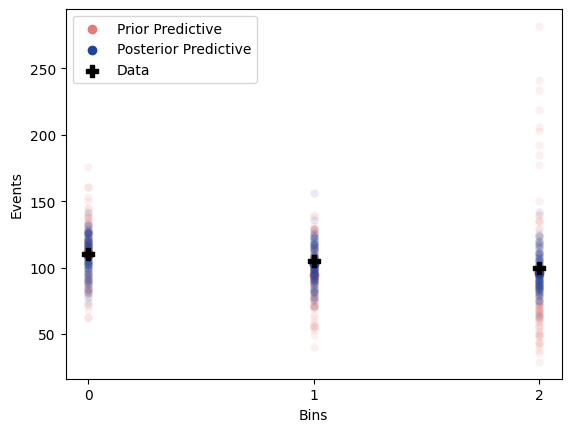

In [7]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=1)